In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
biomass_history = pd.read_csv("data/Biomass_History.csv")
biomass_history.drop(["Index"],axis=1, inplace=True)
x_labels = ["Latitude","Longitude","2010","2011","2012","2013","2014","2015","2016","2017"]
y_data = biomass_history.loc[:, x_labels]
y_data_np = y_data.to_numpy()

In [21]:
def colored_scatter_plot(x, y, data_for_color):
    plt.scatter(x, y, s=15, c=data_for_color, cmap='plasma')
    plt.show()
    return plt

In [ ]:
lon = y_data_np[:,1] #the x coord
lat = y_data_np[:,0] #the y coord
z = y_data_np[:,9]

colored_scatter_plot(lon, lat, z)

In [4]:
def euc_dist_sq(x1,y1,x2,y2):
    return np.abs((x2-x1)**2 + (y2-y1)**2)

In [5]:
def gen_rand_coords(min, max, size):
    return (max-min)*np.random.rand(size) + min

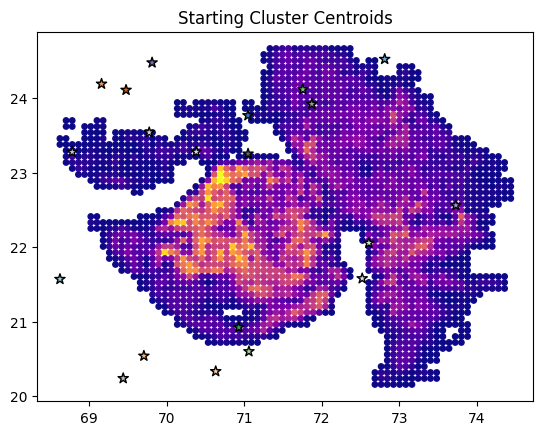

Iteration  0 of  100
Got Here
Iteration  1 of  100
Got Here
Finished Clustering


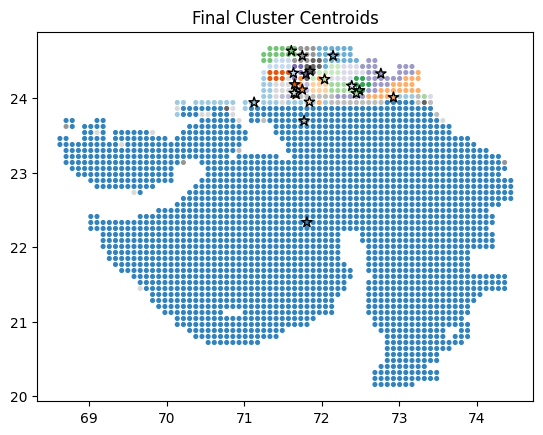

[366664.996  18999.999  19000.     19000.     18999.999  18999.999
  18999.999  18999.999  19000.     18999.999  18999.999  18999.999
  18999.999  19000.     19000.     18999.999  18999.999  18999.998
  18999.999  19000.   ]


In [17]:
#Clustering Code
DEPOTS = 20
MAX_ITER = 100
DEPOT_PROC_LIMIT = 19_000

#Seed the rand gen
np.random.seed(1)

min_lat = np.min(y_data_np[:,0])
max_lat = np.max(y_data_np[:,0])

min_lon = np.min(y_data_np[:,1])
max_lon = np.max(y_data_np[:,1])

lon = y_data_np[:,1] #the x coord
lat = y_data_np[:,0] #the y coord

biomass_data = y_data_np[:,9] #the biomass data for 2017

#Gather the point coords for convenience
point_coords = np.column_stack((lon,lat))

#Generate random centeroid coords
x_centers = gen_rand_coords(min_lon, max_lon, DEPOTS)
y_centers = gen_rand_coords(min_lat, max_lat, DEPOTS)
centroid_coords = np.column_stack((x_centers, y_centers))
new_centroid_coords = np.zeros_like(centroid_coords)

#Just for the coloring for the scatter plot
cols = np.arange(0, DEPOTS, 1)

plt.scatter(lon, lat, s=15, c=biomass_data, cmap='plasma')
plt.scatter(x_centers, y_centers, s=60, marker='*', c=cols, cmap='tab20c', edgecolors='black')
plt.title("Starting Cluster Centroids")
plt.show()

#This array will tell you which cluster each point in point_coords belongs to. (0-24)
current_cluster_idx = np.zeros(shape=(point_coords.shape[0],))
new_cluster_idx = np.zeros(shape=(point_coords.shape[0],))

#This array is used in the computation of the distances from a point to each of the clusters
distances = np.zeros(shape=(DEPOTS,))
biomass_holding = np.zeros(shape=(DEPOTS,))



# This is the main k-means clustering loop. The 'i' var is iterations
for i in range(MAX_ITER):
    print("Iteration ", i, "of ", MAX_ITER)
    for j in range(point_coords.shape[0]):
        for k in range(centroid_coords.shape[0]):
            distances[k] = euc_dist_sq(point_coords[j,0], point_coords[j,1], centroid_coords[k,0], centroid_coords[k,1])
            
            for deps in range(DEPOTS):
                potential_cluster = np.argmin(distances)

                #Check if adding the cluster would push the depot past its capacity.
                #If it doesn't then add it to the cluster as normal
                if(biomass_holding[potential_cluster] + biomass_data[j] < DEPOT_PROC_LIMIT):
                    new_cluster_idx[j] = potential_cluster
                    biomass_holding[potential_cluster] += biomass_data[j]
                    break
                else:
                    #If it does push the depot past its capacity. Set that distance to INT_MAX
                    #i.e. never add it to the cluster. 
                    distances[potential_cluster] = np.iinfo(np.int16).max

    
    
    #Break early if the clusters don't change from the previous iteration.
    if(np.array_equal(new_cluster_idx, current_cluster_idx)):
        print("Finished Clustering")
        break
    else:
        current_cluster_idx = new_cluster_idx



    for j in range(centroid_coords.shape[0]):
        idxs = np.where(current_cluster_idx == j)
        mean_coords = np.mean(point_coords[idxs[0], :2], axis=0)
        biomass_holding[j] = np.sum(biomass_data[idxs[0]])


        if(np.isnan(mean_coords[0]) == False):
            new_centroid_coords[j,:] = mean_coords
        else:
            new_centroid_coords[j,0] = gen_rand_coords(min_lon, max_lon, 1)
            new_centroid_coords[j,1] = gen_rand_coords(min_lat, max_lat, 1)

    centroid_coords = new_centroid_coords


plt.scatter(lon, lat, s=7, c=current_cluster_idx, cmap='tab20c')
plt.scatter(centroid_coords[:,0], centroid_coords[:,1], marker='*', s=60, c=cols, cmap='tab20c', edgecolors='black')
plt.title("Final Cluster Centroids")
plt.show()

print(biomass_holding)


